In [154]:
# import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import math

In [155]:
# use GPU
if torch.backends.mps.is_available():
    processor = 'mps'
elif torch.cuda.is_available():
    processor = 'cuda'
else:
    processor = 'cpu'
device = torch.device(processor)
print(device)

mps


In [156]:
class fractal:
    def __init__(self, fractal, colour, device, param = 2, infinity = 8 ):
        # setting the fractal that we are going to be making, this should be a string that is inputted in creation
        self.fractal = fractal 
        # The colour scheme used in plotting
        self.colour = colour
        # the fil
        self.actual_fractal = 0
        self.device = device
        self.param = param
        self.infinity = infinity

    def compute_fractal(self, xmin = -1, xmax = 1, ymin = -1, ymax = 1, w = 3200, h = 2400, maxiter = 256):
        
        x = torch.linspace(xmin, xmax, w, dtype=torch.float,device=self.device).type(torch.half) #w = window's width in pixels; xmin, xmax = left and right borders of the window
        y = torch.linspace(ymin, ymax, h, dtype=torch.float,device=self.device).type(torch.half) #h = window's height in pixels; ymin, ymax = bottom and up borders of the window
        
        #create two tensors, containing respectively all x and y coordinates of all the points in the window. c=[cx,cy]
        cx, cy = torch.meshgrid([x,y])
    
        #set initial value of variable z to zero for the z=z^2+c 
        zx = torch.zeros(w*h, dtype=torch.float32,device=self.device).type(torch.half).resize_as_(cx)
        zy = torch.zeros(w*h, dtype=torch.float32,device=self.device).type(torch.half).resize_as_(cy)
        
        #will represent the color of the pixel, ininitialy 0. Tensor's shape is the same as that of cx, cy, zx and zy
        k = torch.zeros(w*h, dtype=torch.uint8,device=device).reshape(w,h)
        
        for i in range(maxiter):
            zx2 = zx**2 
            zy2 = zy**2
            #escaped is a tensor containing true for all the points that have escaped on the last generation
            escaped = (zx2+zy2)>self.infinity**2 # this is a calculation over all the points to check if they have escaped
            k[escaped] = i #for all the points escaping to infinity, store the number of iteration when that was this discovered
            cx, cy , zx, zy = self.compute_escape(cx,cy,zx,zy,i)
            
        self.actual_fractal = k.t()
    
    def draw(self, smoothing = True):
        if smoothing== True:
            M = torch.log(self.actual_fractal/256)+1
            M = M.cpu()
        else: 
            M = self.actual_fractal.cpu()
        plt.figure(figsize=(3.200, 2.400), dpi=1000)
        img = plt.imshow(M)
        img.set_cmap(self.colour)
        plt.axis('off')
        plt.savefig('myfig.png', dpi=1000)
        
    # As of yet pytorch backend for apple silicon does not support complex numbers, therefore to make this work someone has to calculate
    # the symbolic real and imaginary parts of the files manually. I've done if for some of the easier ones but it is unpleasant.
        
    def compute_escape(self, cx,cy,zx,zy,iteration):
        if iteration == 0:
            zx = cx
            zy = cy
        if self.fractal == 'mandelbrot':
            return cx,cy, self.param*(zx**2 -zy**2) + cx , self.param*(2* zx*zy)+ cy
        elif self.fractal == 'sin':
            return cx, cy, zx * (torch.sin(zx)*torch.cosh(zy)) - zy * (torch.cos(zx) * torch.sinh(zy)) ,zy * (torch.sin(zx)*torch.cosh(zy)) + zx * (torch.cos(zx) * torch.sinh(zy))
        elif self.fractal == 'nova':
            return cx,cy, zx - self.param*2*(2*zx**3 - 6*zx*(zy**2)-2)/(3*zx**2-3*zy**2) + cx , zy -self.param * (6*(zy**2) * zy- 2*zy**3 )/(3*zx**2-3*zy**3)+cy
        else: 
            return  cx,cy,zx,zy,
        



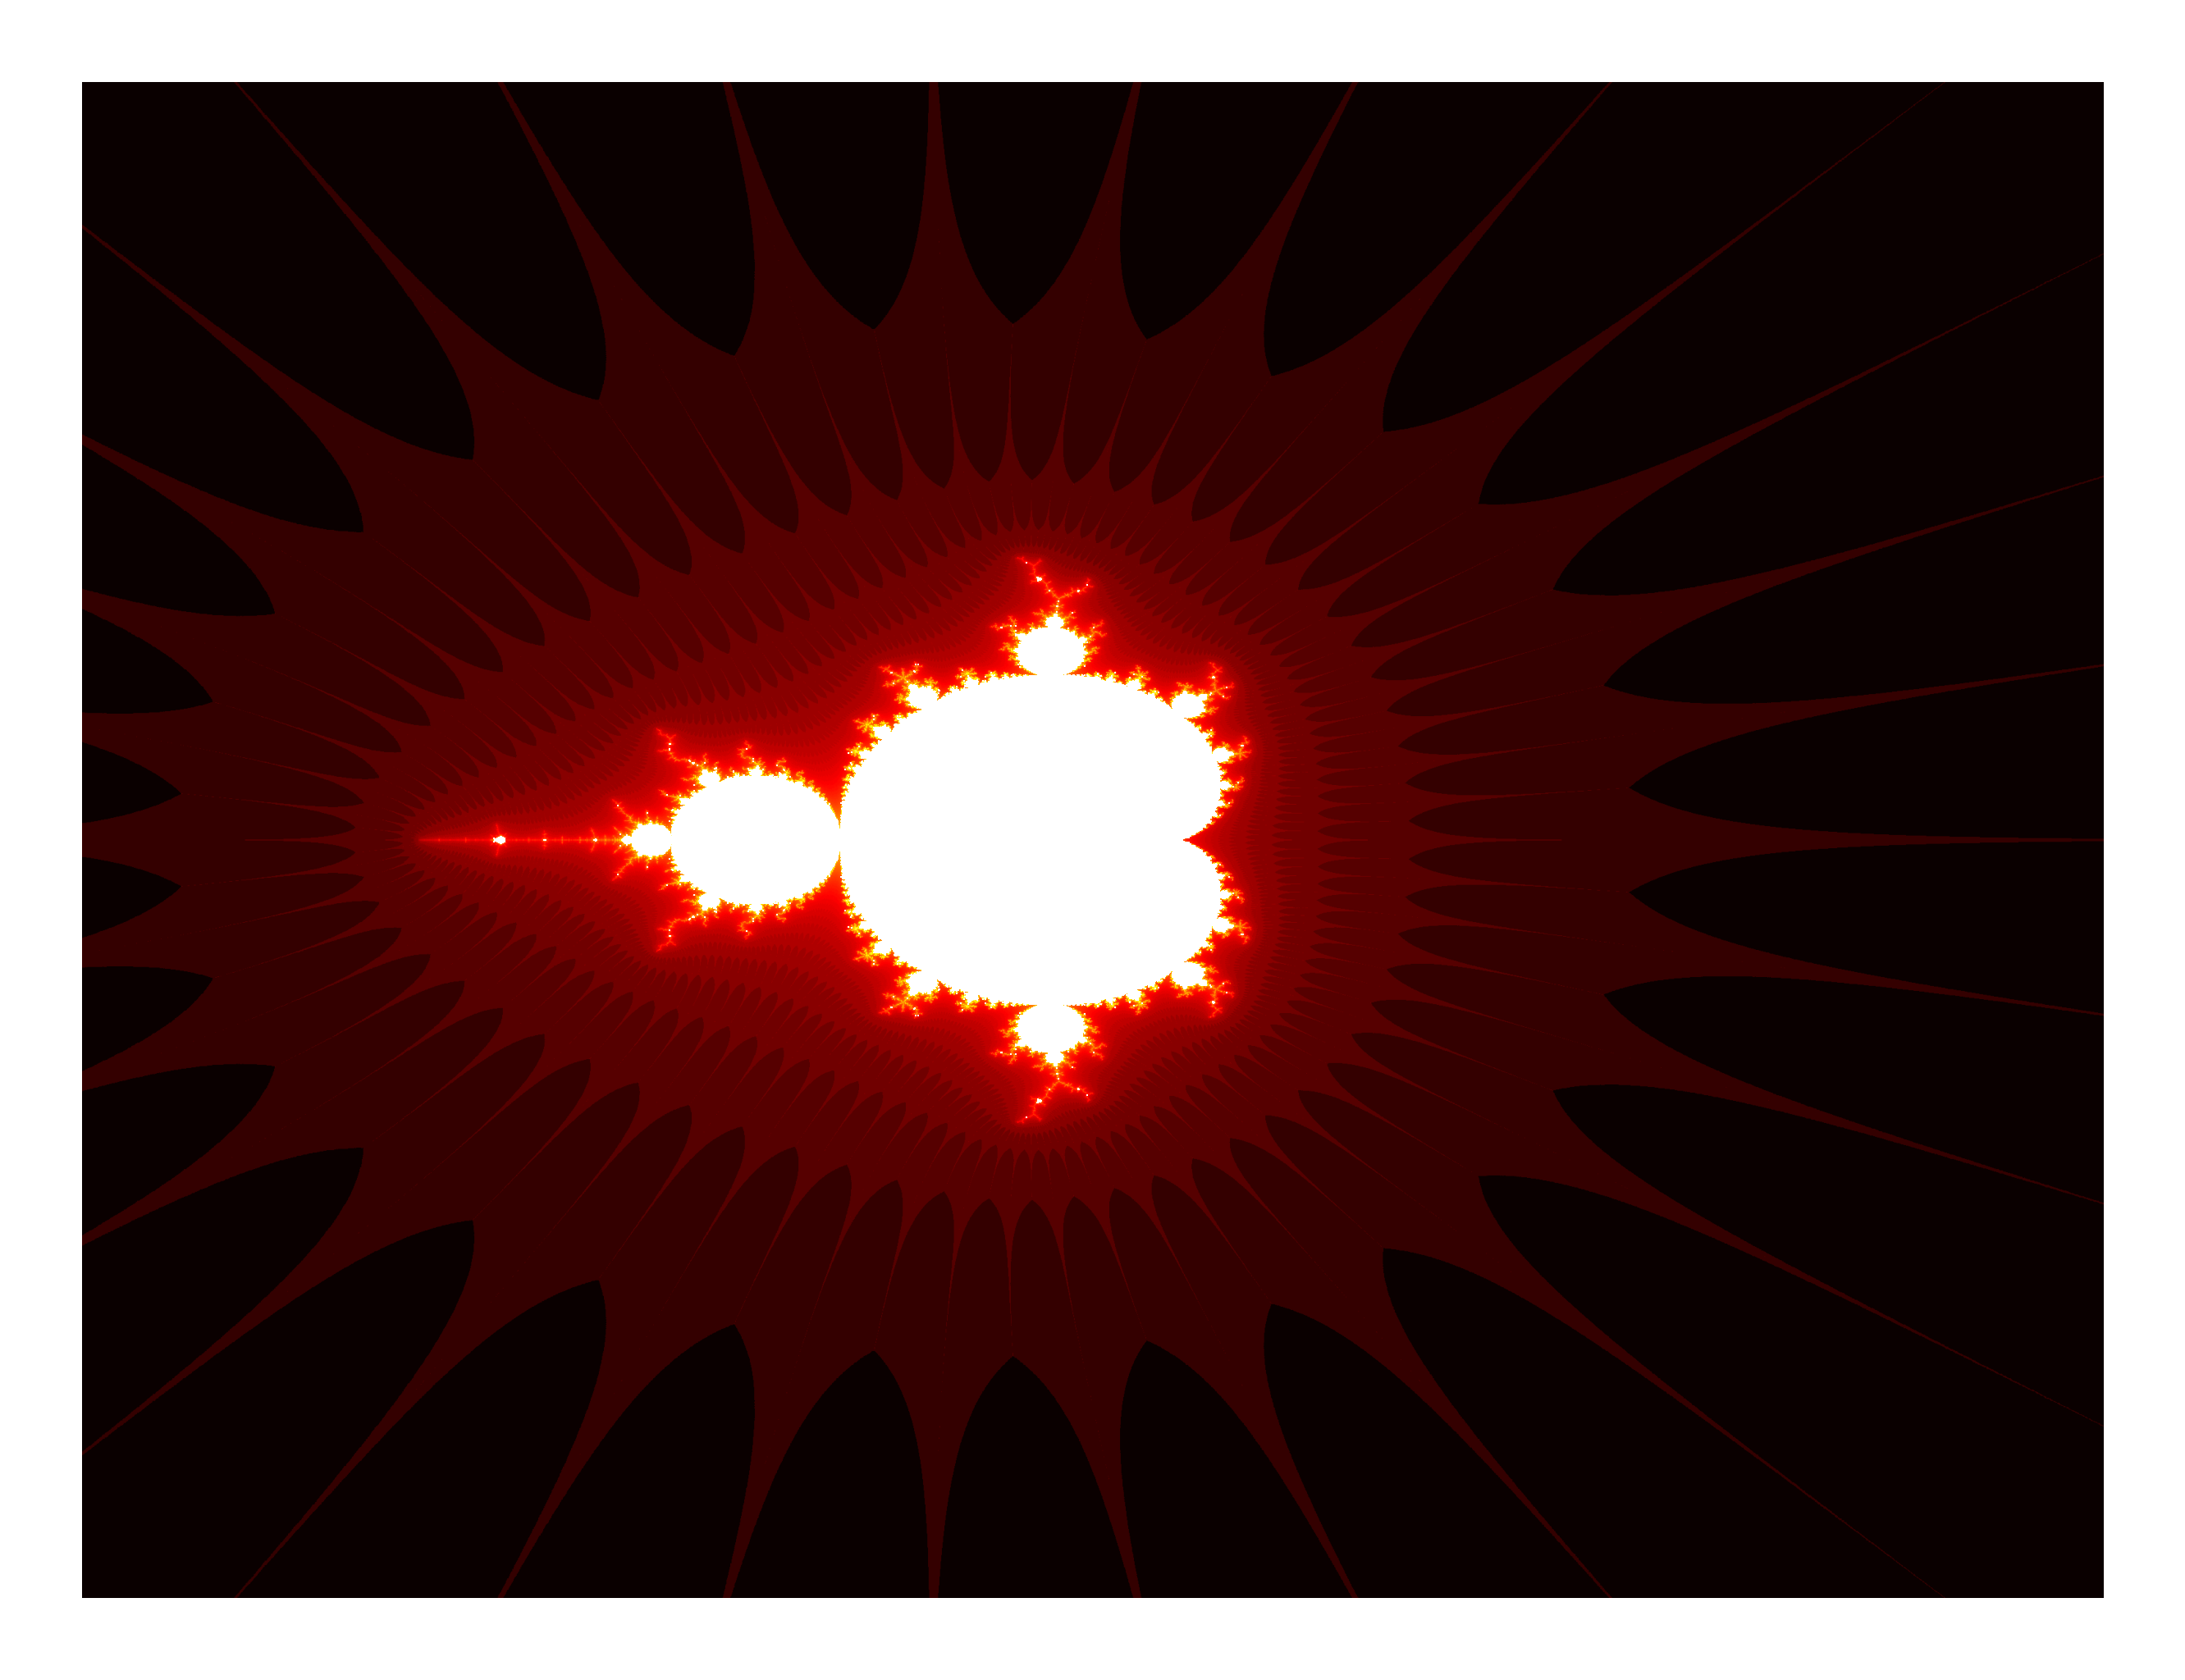

In [157]:
mandi = fractal('mandelbrot', 'hot', device, 1, 4)
mandi.compute_fractal(xmin = -3, xmax = 3, ymin = -3, ymax = 3, w = 3200, h = 2400, maxiter = 256)
mandi.draw()